In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import statsmodels.api as sm


# Change in Data Explanation

**Summary:** I changed my data and project slightly because I found working with multiple datasets that I couldn't  combine to be too difficult, and I don't really have the time in my schedule to do all of the test and work for that, especially since I'm doing this solo. All I did was remove the datasets so that I only have one. This dataset contains a lot of information about mass shootings throughout the decades. Since I only have this one dataset I also changed my project goal from analyzing differences in gun violence between the US and other countries to analyzing mass shootings in just the US. I will be trying to spot trends and looking for possible warning signs through the trends I spot.

# US Mass Shooting Data

**Importing, Parsing & Organizing**



In [120]:
mass_shootings_5 = pd.read_csv('Mass Shootings Dataset Ver 5.csv', encoding='cp1252')

mass_shootings_5 = mass_shootings_5.drop(columns=['Title', 'S#', 'Incident Area', 'Summary', 'Fatalities', 'Injured', 'Age', 'Employeed (Y/N)', 'Employed at', 'Latitude', 'Longitude'])

mass_shootings_5

def remove_city(location):
  if str(location) != 'nan':
    splitted_loc = location.split()
    if splitted_loc[-2] in ['New', 'North', 'Rhode', 'South', 'West']:
      state = splitted_loc[-2] + ' ' + splitted_loc[-1]
    else:
      state = splitted_loc[-1]
    return state

def fix_target(target):
  target = str(target).lower()

  if target != 'nan':
    if ('ex-' in target):
      target = 'Ex-Person(s)'
    elif (('teacher' in target) | ('student' in target) | ('teachers' in target) | ('students' in target) | ('school' in target)):
      target = 'School'
    elif ('child' in target):
      target = 'Children'
    elif (('congress' in target) | ('police' in target) | ('council' in target) | ('social worker' in target) | ('tsa' in target) | ('marine' in target)):
      target = 'Government Employee(s)'
    elif (('coworker' in target) | ('friend' in target) | ('neighbor' in target) | ('guest' in target) | ('employee' in target)):
      target = 'Relationship (non-familial)'
    elif ('family' in target):
      target = 'Family'
    elif ('random' in target):
      target = 'Random'
    elif ('women' in target):
      target = 'Women'
    elif (('black' in target) | ('white' in target) | ('sikhs' in target) | ('monk' in  target) | ('pray' in target)):
      target = 'Race/Religion'
    else:
      target = 'Other'

    return target

def fix_cause(cause):
  cause = str(cause).lower()

  if ('frustration' == cause):
    cause = 'anger'
  elif ('nan' == cause):
    cause = 'unknown'
  elif (('domestic' in cause) | ('breakup' == cause)):
    cause = 'domestic'
  elif (('exam' in cause) | ('suspension' == cause)):
    cause = 'school'

  return cause

mass_shootings_5['Location'] = mass_shootings_5['Location'].apply(remove_city) # remove city/county
mass_shootings_5['Target'] = mass_shootings_5['Target'].apply(fix_target)
mass_shootings_5['Cause'] = mass_shootings_5['Cause'].apply(fix_cause)

states = {
    'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AZ': 'Arizona','CA': 'California',
    'CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida',
    'GA': 'Georgia','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois',
    'IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts',
    'MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri',
    'MS': 'Mississippi','MT': 'Montana','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska',
    'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York',
    'OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island',
    'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah',
    'VA': 'Virginia','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia',
    'WY': 'Wyoming','PR': 'Puerto Rico','VI': 'Virigin Islands', 'D.C.': 'District of Columbia'
    }

mass_shootings_5['Location'] = mass_shootings_5['Location'].replace(states) # replace abbreviations
us_mass_shootings = mass_shootings_5.rename(columns={'Total victims': 'Total Victims'}) # rename columns

us_mass_shootings

,Location,Date,Open/Close Location,Target,Cause,Total Victims,Policeman Killed,Mental Health Issues,Race,Gender
0,Texas,11/5/2017,Close,Random,unknown,46,0.0,No,White,M
1,Colorado,11/1/2017,Open,Random,unknown,3,0.0,No,White,M
2,Maryland,10/18/2017,Close,Relationship (non-familial),unknown,6,0.0,No,Black,M
3,Nevada,10/1/2017,Open,Random,unknown,585,1.0,Unclear,White,M
4,California,6/14/2017,Close,Relationship (non-familial),unknown,5,0.0,Yes,Asian,M
...,...,...,...,...,...,...,...,...,...,...
318,Illinois,1/17/1974,Close,School,anger,4,0.0,Yes,Unknown,Male
319,Louisiana,12/31/1972,NaN,Random,psycho,22,4.0,Yes,Black American or African American,Male
320,Washington,11/11/1971,Close,Random,terrorism,5,0.0,Yes,White American or European American,Male
321,Arizona,11/12/1966,Close,Random,terrorism,6,0.0,Yes,White American or European American,Male


# Statistical Test #1

**Chi-Squared**

I want to see if mental health has an effect on the target. In order to do this I will use a Chi-Squared Test since this data is categorical.

First I will define the hypothesis:

*   **HO:** Mental health has no effect on the target of a mass shooting.
*   **HA:** Mental health does have an effect on the target of a mass shooting.

> Now I will start by making a contingency table.



In [153]:
new_df = us_mass_shootings[(us_mass_shootings['Mental Health Issues'] == 'Yes') | (us_mass_shootings['Mental Health Issues'] == 'No')]

contingency_table = pd.crosstab(new_df['Target'], new_df['Mental Health Issues'])
contingency_table

Mental Health Issues,No,Yes
Target,,
Children,0,2
Ex-Person(s),7,14
Family,9,8
Government Employee(s),4,6
Other,3,2
Race/Religion,3,1
Random,37,43
Relationship (non-familial),15,10
School,13,19


> Now that I have that, I will plot it using a bar graph to show the relationship between the different categories and mental health issues.

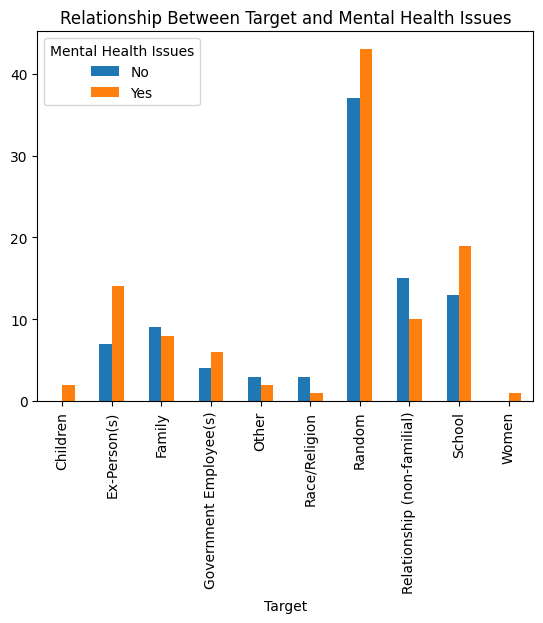

In [154]:
plot = contingency_table.plot(kind='bar', title='Relationship Between Target and Mental Health Issues')

> Now I will obtain the p-value in order to see if I can reject or fail to reject the null hypothesis.

In [84]:
chi2, p_value, dof, ex = chi2_contingency(contingency_table)
p_value

0.48715665898535343

**Analysis & Conclusion**:

> As you can see the p-value is greater than the alpha(.05) so I fail to reject the null hypothesis. This means that there is no direct relation between the target and if the shooter has mental health issues. I expected to be able to reject the null hypothesis, so this is surprising. When doing the final deliverable for this project I will try to find more data about the relationship between mass shootings and mental health since I do find this part of the issue to be very important.

# Statistical Test #2

**Mann-Whitney U**

I want to see if the location being opened or closed has an affect on the amount of injuries. In order to do this I will use Mann-Whitney U since the  groups are independent and not normally distributed.

First I will define our hypothesis:

*   **HO:** The location being opened or closed has no affect on the amount of injuries.
*   **HA:** The location being opened or closed has an affect on the amount of injuries.

> Now I will start by seperating the opened and closed locations and their total injuries


In [155]:
open_location = us_mass_shootings[us_mass_shootings['Open/Close Location'] == 'Open']['Total Victims']
closed_location = us_mass_shootings[us_mass_shootings['Open/Close Location'] == 'Close']['Total Victims']

> Now I will create a Box-Plot to compare the data.

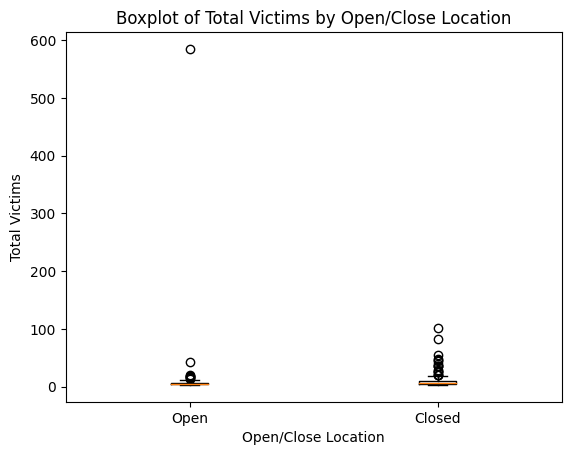

In [156]:
plt.xlabel('Open/Close Location')
plt.ylabel('Total Victims')
plt.title('Boxplot of Total Victims by Open/Close Location')
plt.boxplot([us_mass_shootings[us_mass_shootings['Open/Close Location'] == 'Open']['Total Victims'], us_mass_shootings[us_mass_shootings['Open/Close Location'] == 'Close']['Total Victims']],
            labels=['Open', 'Closed'])

plt.show()

> There are some pretty high outliers which may affect the distribution of the data, but I want to zoom in a little bit so that I can actually see the box plots.

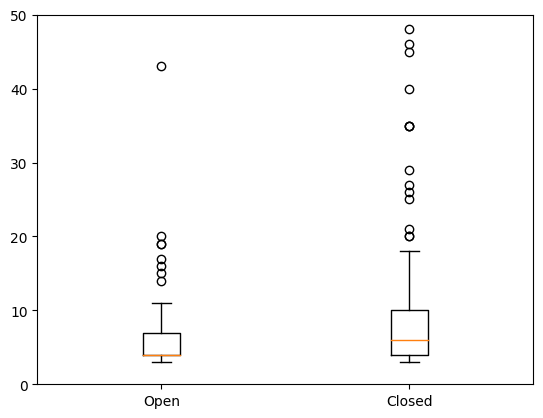

In [157]:
plt.boxplot([us_mass_shootings[us_mass_shootings['Open/Close Location'] == 'Open']['Total Victims'], us_mass_shootings[us_mass_shootings['Open/Close Location'] == 'Close']['Total Victims']],
            labels=['Open', 'Closed'])
plt.ylim(0,50)
plt.show()

> In the box plots they both are right skewed, so on average both open and closed locations are greater than their medians. The open location box plot is probably more skewed because it has much higher outliers than the closed location.

> Now I will obtain the p-value to see if I can reject or fail to reject the null hypothesis.



In [146]:
statistic, p_value = mannwhitneyu(open_location, closed_location)

p_value

0.03603286133592586

> **Analysis & Conclusion:** The
p-value is less than the alpha (.05) so we can reject the null hypothesis. Since I can reject the null hypothesis, I can now try to explore what that affect may be, as in which one has greater or less total victims. This is something I can explore and go deeper into for the final deliverable.

# Statistical Test #3

**ANOVA/Kruskal Test**

> For this test I want to compare the causes to each other in relation to how many total victims they each have. In order to do this I will create a bar graph that compares the average number of victims in each seperate.

In [158]:
averages = us_mass_shootings.groupby('Cause').agg({'Total Victims': 'mean'}).reset_index()
averages.columns = ['Cause', 'Average Total Victims']

averages

,Cause,Average Total Victims
0,anger,6.290323
1,domestic,3.928571
2,drunk,9.000000
3,psycho,8.441176
4,racism,9.000000
5,religious radicalism,9.000000
6,revenge,6.100000
7,robbery,9.000000
8,school,6.250000
9,terrorism,13.461538


> Now I want to know what the overall mean is between the categories so that I can see how it the specific causes compare.

In [148]:
causes_mean = averages['Average Total Victims'].mean()
causes_mean

8.748457123712763

> Now I am going to create a bar graph to compare the means of the cause with each other as well as with the overall mean.

<Axes: xlabel='Cause', ylabel='Average Total Victims'>

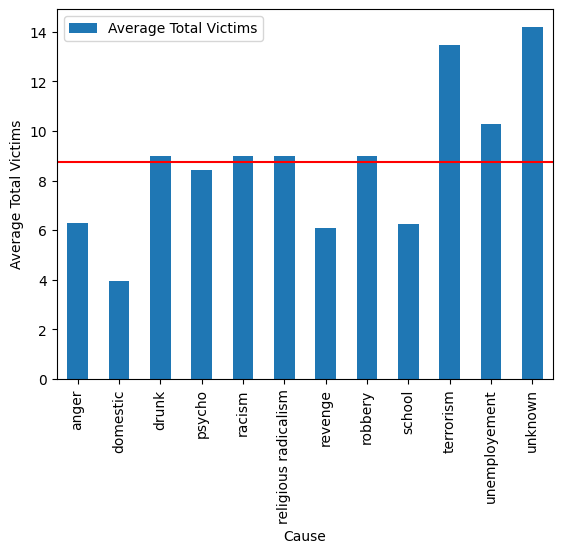

In [159]:
plot = averages.plot.bar(x='Cause', y='Average Total Victims')
plt.axhline(y=causes_mean, color='r', linestyle='-')
plt.ylabel('Average Total Victims')
plot

> With this bar graph I can see the relationship between the different causes and how they differ from each other when it comes to the average amount of victims harmed. I can also compare that to the overall mean to see where they lie.

> I think it would be good to do an ANOVA tests on this to see if there is a difference among the groups, but in order to do this we first have to make sure the data is normally distributed.



*   **HO:** The means will be the same accross all groups, so the group has no affect on total victims.
*   **HA:** The means won't be the same accross all groups, so the group has an affect on total victims.



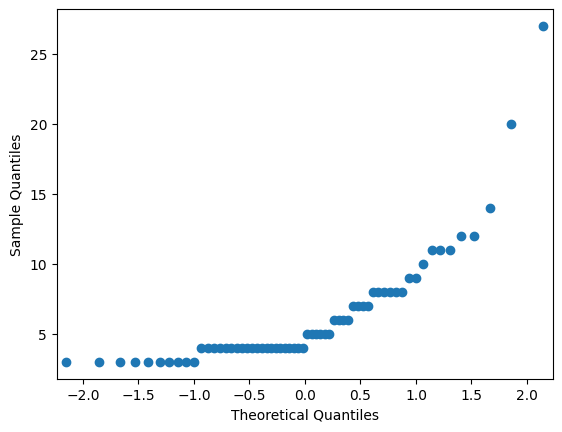

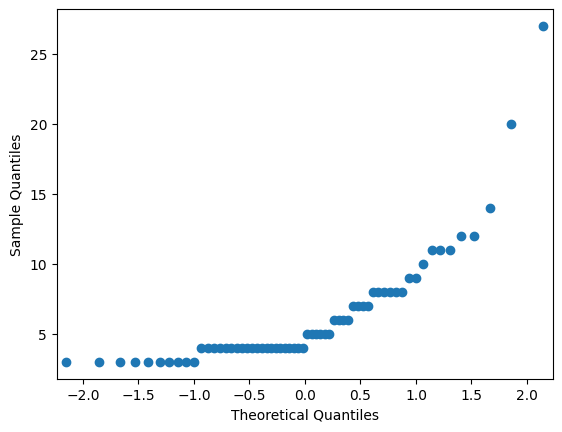

In [160]:
dist = us_mass_shootings[us_mass_shootings['Cause'] == 'anger']['Total Victims']
sm.qqplot(dist)

> Since the points aren't in a straight line, I can assume the data isn't normally distributted, so I can't do an ANOVA test sadly. Instead, I will try a Kruskal-Wallis Test.

In [161]:
anger = us_mass_shootings[us_mass_shootings['Cause'] == 'anger']['Total Victims']
unemployement = us_mass_shootings[us_mass_shootings['Cause'] == 'unemployement']['Total Victims']
racism = us_mass_shootings[us_mass_shootings['Cause'] == 'racism']['Total Victims']
domestic =us_mass_shootings[us_mass_shootings['Cause'] == 'domestic dispute']['Total Victims']
pyscho = us_mass_shootings[us_mass_shootings['Cause'] == 'psycho']['Total Victims']
revenge = us_mass_shootings[us_mass_shootings['Cause'] == 'revenge']['Total Victims']
school = us_mass_shootings[us_mass_shootings['Cause'] == 'school']['Total Victims']
religious_radicalism = us_mass_shootings[us_mass_shootings['Cause'] == 'religious radicalism']['Total Victims']
drunk = us_mass_shootings[us_mass_shootings['Cause'] == 'drunk']['Total Victims']
robbery = us_mass_shootings[us_mass_shootings['Cause'] == 'robbery']['Total Victims']

stat, p_value = kruskal(anger, unemployement, racism, domestic, pyscho, revenge, school, religious_radicalism, drunk, robbery)

p_value

nan

> **Analysis & Conclusion** The p-value I get is NaN, which I shouldn't be getting. I must be doing the test wrong, but don't have enough time to figure it out sadly. If the p_value was less than .05, then I could assume that the means are not equal, I could then do some Post-HOC test in order to determine the differences between causes. If it was greater than, then I'd say the means are the same.